In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
def load_and_prep_cifar(batch_size,shuffle_buffer_size):
    (train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train','test'], as_supervised=True, with_info=True)
    #tfds.show_examples(train_ds,ds_info)

    def preporcessing_func(img,label):
        img = tf.cast(img, tf.float32)
        img = (img/128) -1
        label = tf.one_hot(label, depth = 10)
        return img, label
    
    train_ds = train_ds.map(lambda img, label: preporcessing_func(img, label))
    train_ds = train_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    test_ds = test_ds.map(lambda img, label: preporcessing_func(img, label))
    test_ds = test_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    return train_ds, test_ds

In [29]:
def create_my_cifar_cnn(name='my_cnn'):
    inputs = tf.keras.Input(shape=(32,32,3),dtype= tf.float32)
    #filters & kernel_size
    cnn_layer_1 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu', padding='same')
    x = cnn_layer_1(inputs) # shape [batch_size, 32, 32, 5]
    cnn_layer_2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', padding='same')
    x = cnn_layer_2(x) # shape [batch_size, 32, 32, 10]
    cnn_layer_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')
    x = cnn_layer_3(x) # shape [batch_size, 32, 32, 64]
    global_pooling = tf.keras.layers.GlobalAveragePooling2D()
    x = global_pooling(x) #shape: [batch_size, 64] (feature_vector)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')
    output = output_layer(x)
    model = tf.keras.Model(inputs=inputs,outputs=output, name=name)
    return model

In [30]:
def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_loss_aggregator.append(np.mean(sample_test_loss))
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [31]:
def train(num_epochs, batch_size, shuffle_buffer_size, lr):
    model = create_my_cifar_cnn()
    data, test_data = load_and_prep_cifar(batch_size=batch_size,shuffle_buffer_size=shuffle_buffer_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_f = tf.keras.losses.CategoricalCrossentropy()

    test_accuracy = tf.keras.metrics.Accuracy()
    train_losses = tf.keras.metrics.CategoricalCrossentropy()
    test_loss= tf.keras.metrics.CategoricalCrossentropy()
    epoch_test_acc = []
    epoch_train_los = []
    epoch_test_los = []

    for epoch in tqdm(range(num_epochs)):       
        for x, t in data:
            with tf.GradientTape() as tape:
                pred = model(x)
                l = loss_f(t, pred)
                train_losses.update_state(t,pred)
            gradients = tape.gradient(l, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for (input, target) in test_data:
            prediction = model(input)
            test_accuracy.update_state(tf.argmax(target, 1), tf.argmax(prediction,1))
            test_loss.update_state(prediction,target)

        epoch_test_acc.append(test_accuracy.result().numpy())
        epoch_test_los.append(test_loss.result().numpy())
        epoch_train_los.append(train_losses.result().numpy())

        train_losses.reset_state()
        test_accuracy.reset_state()
        test_loss.reset_state()

    return epoch_train_los, epoch_test_los, epoch_test_acc
            

In [32]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
NUM_EPOCHS = 20
LR = 0.001

train_loss, test_loss, test_acc = train(num_epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,lr=LR)

100%|██████████| 20/20 [18:17<00:00, 54.86s/it]


In [33]:
plotting = {}
plotting["fewer units"] = [train_loss, test_loss, test_acc]

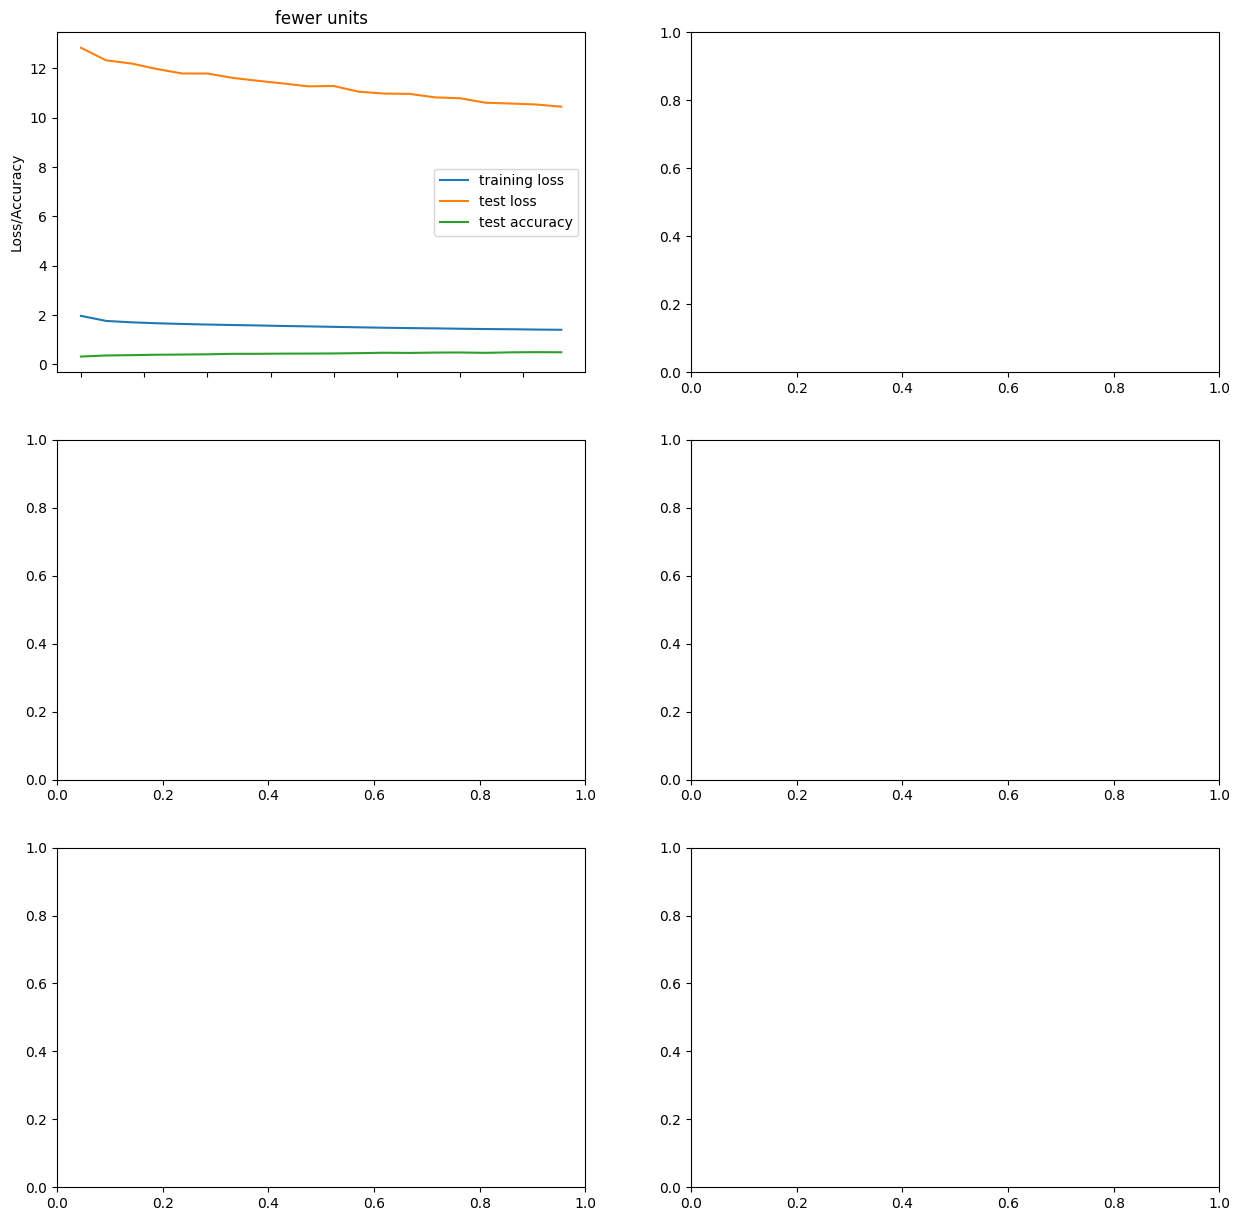

In [35]:
# plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for ax, key in zip(axs.flat, plotting.keys()):
    
    train_losses, test_losses, test_accuracies = plotting[key]
    
    line1, = ax.plot(train_losses)
    line2, = ax.plot(test_losses)
    line3, = ax.plot(test_accuracies)
    ax.legend((line1,line2, line3),("training loss","test loss", "test accuracy"))
    ax.set_title(key)
    ax.set(xlabel="Training steps", ylabel="Loss/Accuracy")
    ax.label_outer()
    
plt.show()